<h2>Importing Libraries</h2>

In [1]:
import pandas as pd
import numpy as np
import re

from textblob import TextBlob

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.add("though")
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)

<br>

<h2>Reading the data</h2>

In [2]:
products_df = pd.read_excel(r"C:\Users\Monis\OneDrive\Desktop\Plaksha\1_Academics\Term 2\3_Visualization\1_Assignments\products.xlsx")
reviews_df = pd.read_excel(r"C:\Users\Monis\OneDrive\Desktop\Plaksha\1_Academics\Term 2\3_Visualization\1_Assignments\reviews.xlsx")

<br>

<h2>Functions</h2>

In [3]:
# Cleaning reviews by removing stopwords
# The function takes a review as the input and returns a clean review with stopwords removed
def remove_stopwords(s):
    word_tokens = word_tokenize(s)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []  
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    filtered_sentence = [s.lower() for s in filtered_sentence]
    return " ".join(filtered_sentence)


# Function to clean productname
# The product name has valuable information about the company selling it, the product description and finally the count
# But there is difference in format of these products
# So to ensure richer analysis, I convert a given product name by merging the inbetween product details.
# Example, I convert "Lozperi, Copper Mask, Adult, Black, 1 Mask" to "Lozperi, Copper Mask Adult Black, 1 Mask"
# in the above I have combined Copper Mask, Adult, Black
# The function takes sentence split to a list and 
def comb_prodname(li_text):
    if len(li_text) > 3:
        return li_text[0]+","+" ".join(li_text[1:-1])+","+li_text[-1]
    else:
        return ",".join(li_text)
    

# Creates bigrams and trigrams for a given input review
# Given a reviews, the function splits into phrases contaning 2 or 3 words and the checks the frequency
# The function returns the frequncy of the phrases
def create_ngrams(texts):
    c_vec = CountVectorizer(stop_words=stop_words, ngram_range=(2,3))
    ngrams = c_vec.fit_transform(texts)
    count_values = ngrams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    
    df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k,i in vocab.items()], reverse = True),
                           ).rename(columns  = {0: 'frequency', 1: 'bigram/trigram'})
    
    return df_ngram


# Create WordCloud
# Given a tuple of a phrase and frequence the function plots the phrase with respect to the frequency (size)
def create_WordCloud(d, emo = "", coun = ""):
    tuples = [tuple(x)[::-1] for x in d.values]
    wordcloud = WordCloud(collocations = False, background_color = 'white')
    wordcloud.generate_from_frequencies(frequencies=dict(tuples))
    plt.figure()
    plt.figure(figsize=[10,5])
    plt.title(f"most popular {emo} phrase occurences in {coun}", fontdict={'fontsize' : 20})
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

<br><br>

<h1>Introduction</h1>

<p>Data in its raw form disguises the most valuable insights from the users. Data analysis is a task in which an analyst works in uncovering the insights from the data and assist in decision making. Data is ubiquitous and is unrestricted to any fields. From being a job role, it is now a necessary skill in most of the occupations.</p>
<p>The data given in the assignment consists of reviews of safety masks. The data is from an online store called iHerb. The data is rich in user reviews (text), collected in different point in time, across different geographies, and details of individual products. A detailed analysis can help one understand the demand for safety masks in the market and assist in decision making related to investments and profits (from a business perspective).</P>


<br>

<h2>Data cleaning steps and its importance:</h2>

<ol><li>Renaming productId in reviews data to make merge possible with the products data</li>
<ul><li>Having common column names across different dataset help in easier merging of the two datasets easier.>/li></ul>
<li>Extracting country code from language code</li>
<ul><li>Extracting geographical location helps in performing geographical analysis</li></ul>
<li>Cleaning Product Name</li>
<ul>
    <li>Product names are split by commas</li>
    <li>Except for the first and last element, in between elements are used to describe the product</li>
    <li>The description varies in length (element wise)</li>
    <li>Combining helps in making better sense of the product</li>

</ul>
<li>Dropping less important columns</li>
<li>Rescaling ratings from 10s to 1s</li>
<ul><li>Usually rating lies between 1 and 5, but the data has ratings from 10 to 50. That won't fit into the mental model of users. Cleaning will be helpful for lesser cognitive load of users.</li></ul>
<li>Cleaning reviews and replacing reviews in foreign language to respective English translation</li>
<ul><li>Helps in getting better textual analysis. Lesser the data lesser the insight</li></ul>
<li>Dropping Duplicates</li>
<ul><li>Duplicates always mislead analysis. It helps in adding quality to analyses</li></ul>
<li>Extracting company name, num masks purchased, mask type</li>
<ul><li>Helps in getting fine grain data on mask purchases</li></ul>
<li>Creating price per mask for masks bought in group</li>
<ul><li>masks are purchased in different quantity. Price per mask helps avoiding confusion over mask prices</li></ul>
<li>Creating Polarity (sentiment positive, negative) and Subjectivity feature</li>
<ul><li>Understanding polarity helps in getting sentiments of users. It will help in understand the feelings of users.</li></ul>
</ol>


In [4]:
# renaming produt_id in the reviews file so that I can only focus on the relevant comments
reviews_df.rename(columns={'productId' : 'product_id'}, inplace=True)

# Splitting the country code from language codes
reviews_df["Country_Code"] = reviews_df["languageCode"].apply(lambda x: str(x).split("-")[-1])

# scales down reviews from 10s digit to 1s digit (50 -> 5)
reviews_df["Rating"] = reviews_df["ratingValue"].apply(lambda x: int(x/10))

# dropping columns price_currency, product_availability, product_url, source_url
products_df1 = products_df.drop(columns=["price_currency", "product_availability", "product_url", "source_url"])

# 'customerNickname', 'helpfulNo', 'helpfulYes', 'imagesCount', 'languageCode', 'languageCode.1', 'score'
reviews_df_1 = reviews_df.drop(columns=['customerNickname', 'helpfulNo', 'helpfulYes', 'imagesCount', 'languageCode', 'languageCode.1', 'score', 'ratingValue'])

# Cleaning product name
products_df1["product_name"] = products_df1["product_name"].apply(lambda x: comb_prodname(x.split(",")).strip())

# Check the language column and replace accordingly 
# merging reviews and products df
merged_df = pd.merge(reviews_df_1, products_df1, on=["product_id"], how="inner")

# Replacing null reviews with translated reviews
merged_df["clean_review_text"] = np.where((merged_df["translation.reviewText"].isna()), merged_df["reviewText"], merged_df["translation.reviewText"])

# removing noise from the data (could have been retained, but I chose to drop it because it was only 2 rows)
merged_df = merged_df[~merged_df["clean_review_text"].isna()]
merged_df = merged_df[merged_df["clean_review_text"] != 4]
merged_df.reset_index(drop=True, inplace=True)

# removing extra spaces and symbols from reviews
merged_df["clean_review_text"] = merged_df["clean_review_text"].apply(lambda x: " ".join(x.split()))
merged_df["clean_review_text"] = merged_df["clean_review_text"].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

# Removing duplicates from the dataset (there were 84 duplicates in the data)
merged_df = merged_df.drop_duplicates(subset=["id"], keep="first")
merged_df.reset_index(drop=True, inplace=True)

# Getting company name, the number of masks, type of masks from the product_name column
merged_df["company_name"] = merged_df["product_name"].apply(lambda x: x.split(",")[0].strip())
merged_df["num_masks"] = merged_df["product_name"].apply(lambda x: int(x.split(",")[-1].strip().split()[0]))
merged_df["mask_type"] = merged_df["product_name"].apply(lambda x: x.split(",")[1].strip())

# getting price per mask using the num masks column
merged_df["product_price"] = merged_df["product_price"].apply(lambda x: float(x))
merged_df["price_per_piece"] = merged_df["product_price"] / merged_df["num_masks"]

# Creating polarity and subjctivity features using reviews
merged_df["polarity"] = merged_df["clean_review_text"].apply(lambda x: TextBlob(x).polarity)
merged_df["subjectivity"] = merged_df["clean_review_text"].apply(lambda x: TextBlob(x).subjectivity)

# A new feature that checks if the user purchased a single piece mask or a bulk of masks
merged_df["Purchase_Type"] = np.where((merged_df["num_masks"]>1), "bulk", "single")

<br>
<br>

<p>I have specifically addressed the questions given in the assignment through multiple mini analysis</p>

<h1>Exploratory Data Analysis and Visualization</h1>

<h2>1. What is the most popular face mask?</h2>

<p>First, I look at how the use of masks have changed over the given time period. This analysis is useful in comprehending the need for masks to consumers and if there are any external causation that might have increased the use of masks.</p>

<h4>Temporal analysis of consumers' review posting activity</h4>

In [5]:
merged_df["postedDate"] = pd.to_datetime(merged_df["postedDate"], infer_datetime_format=True)
merged_df["Date"] = merged_df["postedDate"].apply(lambda x: x.replace(day=1))
merged_df["Date"] = merged_df["Date"].dt.date

temp_masks = merged_df.groupby(['Date']).agg({'id' : 'count', 'Rating' : 'mean'}).reset_index()
temp_masks["Rating"] = temp_masks["Rating"].round(2)
fig = make_subplots(specs=[[{"secondary_y" : True}]])

fig.add_trace(
    go.Bar(x = temp_masks['Date'].tolist(), y = temp_masks["id"].tolist(), name = "review count",),
    secondary_y = False
)

fig.update_layout(
title_text = "Time series analysis of count (bar) and average ratings (dot) of all consumer reviews",)

fig.add_trace(
    go.Scatter(x = temp_masks['Date'].tolist(), y = temp_masks["Rating"].tolist(), 
               name = "average rating", mode='markers+text', text = temp_masks["Rating"].tolist(),
               textposition = "bottom center", textfont= dict(size = 12, color = 'black')),
    secondary_y = True
)

fig.layout.yaxis2.update(showticklabels=False, showgrid = False)

fig.show()

<b>Inference</b><i> From October 2020 there has been an increase in reviews posted for mask purchases. The ratings for mask products too increased.</i>
<br><b>Why?</b> <i>That was the time when most countries were opening their economies after strict lockdown. The need for masks to ensure social distancing norms increased and hence the sudden raise in mask purchases.</i>


<p><span style="color:blue">I chose multiple graphs to represent the above information because having separate graphs can be a cognitive load to a user viewing the data. Also the count of reviews and mean ratings of products by time gives a wholesome picture of the <b>safety masks market</b>. I have also labelled only the average rating and not the bars because it too many texts can confuse the user. Hence I retained the primary y-axis to explain the review count and removed the secondary y-axis and labelled the red dots instead.</span></p>

<br>

<p>With the given data, popularity of masks can be identified in two ways. One, we can look at how many reviews are posted for each product. And the second, to look at average rating for each product. Average rating acts as a proxy in helping us understand the quality of the masks.</p>

<h4>Analysis of review posting activity at a product level</h4>

In [6]:
prod_avg_count = merged_df.groupby(['product_name']).agg({'Rating' : 'mean', 'id' : 'count'}).reset_index()
prod_avg_count.sort_values(["id"], ascending = False, inplace=True)
prod_avg_count["Rating"] = prod_avg_count["Rating"].round(2)
fig = make_subplots(specs=[[{"secondary_y" : True}]])

fig.add_trace(
    go.Bar(x = prod_avg_count['product_name'].tolist()[:10], y = prod_avg_count["id"].tolist()[:10], name = "review count",
    text = prod_avg_count["id"].tolist()[:10], textposition='none'),
    secondary_y = False
)

fig.add_trace(
    go.Scatter(x = prod_avg_count['product_name'].tolist()[:10], y = prod_avg_count["Rating"].tolist()[:10], 
               name = "average rating", mode='markers+text', text = prod_avg_count["Rating"].tolist()[:10],
               textposition = "bottom center", textfont= dict(size = 12, color = 'black')),
    secondary_y = True
)

fig.layout.yaxis2.update(showticklabels=False, showgrid = False)

fig.update_layout(
    title_text = "Top 10-Product wise average rating (dots) and count of rviews (bars)",
    height = 800
)

fig.update_xaxes(tickangle=75)


fig.show()

<b>Inference </b><i>The top-10 most reviewed masks are either reusable or disposable masks. Masks purchased in bulk usually remain in the range of 3 to 10.</i><br>
<b>Why?</b> <i>There is uncertainty in purchase of bulk masks. If the quality does not meet the expectations then the investment is futile. Interestingly, Zidian masks pack of 50 has good reviews and ratings. That is because those are surgical masks but black in colour (checked the product online).</i>


<h4>Distribution of ratings at a product level</h4>

In [7]:
prod_rev_count_by_rev = merged_df.groupby(['product_name', 'Rating']).agg({ 'id' : 'count'}).reset_index()
fig = px.bar(prod_rev_count_by_rev, x="product_name", y="id", color="Rating", labels={'id' : 'Number of reviews',
                                                                                   'product_id' : 'Product ids'},
            height=1000, title="Distribution of ratings for all the products")
fig.update_xaxes(tickangle=75, )
fig.show()

<b>Inference </b><i>In the above graph we can see that products usually get higher ratings.</i>

<p><span style="color:blue">To represent the product level distribution of ratings, I used a stacked vertical chart because it gives instantly attracts the users to the ratings given to the products. And the help of the gradient scale on the right helps the user differentiate between ratings. I did not use a normalized chart here because the annotations for products with lesser products will be cluttered. Also, a 100% stacked chart will hide the information of the number of masks purchased. A product with only 1 purchase will show 100% for a single rating.</span></p>

<h4>Purchase behaviour of single piece masks vs bulk purchase of masks</h4>

In [8]:
bulk_single_counts = merged_df.groupby(['Date', 'Purchase_Type']).agg({'id' : 'count'}).reset_index()
bulk_single_counts.rename(columns = {'id' : 'Number of reviews'}, inplace=True)

fig = px.line(bulk_single_counts, x='Date', y='Number of reviews', color='Purchase_Type', markers=True, 
              title="Trend of purchase of single vs bulk masks", )
fig.layout.xaxis.update(showgrid = False)
fig.show()

<b>Inference</b><i> The market for bulk masks drastically shifted from June. <br>
<b>Why?</b><i> The reusable nature of bulk masks could have been a possible reason for the shift. It is interesting to see the plateau from July to September and again a drastic increase from October. The plateauing could be the reason of lockdowns and hence it remained low. And from October it could be possible that people were stepping out more often and hence disposable might have surged in demand.</i>
<p>The reason for fall in review count in February is because of incompleteness in data collection. The last date of data collection in February was <b>07th February 2021</b></p>

<p><span style="color:blue">To represent temporal purchase of single vs bulk masks I used line chart because it allows the user to easily compare the difference. Also, the scale of the purchase of both the types did not vary much.</span></p>

<br></br>
<br></br>

<h2>2. What consumers like about the masks?</h2>

<p>From the above analysis, we got an understanding that consumers prefer masks that are either disposable or reusable. And when bought in bulk, consumers prefer a range of 3 to 10 masks in a pack.</p>

<p>A detailed textual analysis can help in understanding consumer requirements. First approach willl be to look at how the word distribution among the reviews look like. To handle for noise we will look at reviews posted for top 10 most reviewed masks.</p>

In [9]:
top_10_prods = merged_df[merged_df["product_name"].isin(prod_avg_count["product_name"].tolist()[:10])]

<h4>Overall frequnce of most occuring phrases in reviews</h4>

<Figure size 432x288 with 0 Axes>

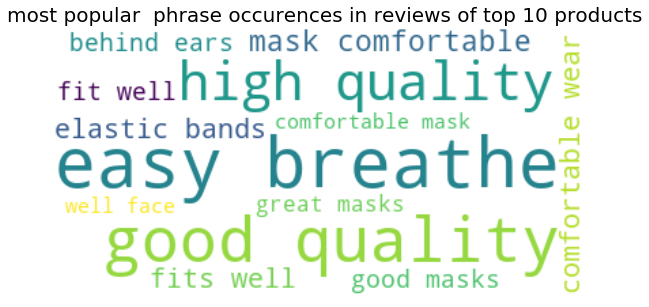

In [10]:
d = create_ngrams(top_10_prods["clean_review_text"]).head(13)
create_WordCloud(d, coun="reviews of top 10 products")

<b>Inference </b><i>The word cloud above highlights prominent aspects that they look for when purchasing masks. One is the fabric quality, second is the comfort, third is the elasticity, and the fourth is the fit of the mask.</i>

<h4>Overall frequnce of most occuring phrases in negative reviews</h4>

<Figure size 432x288 with 0 Axes>

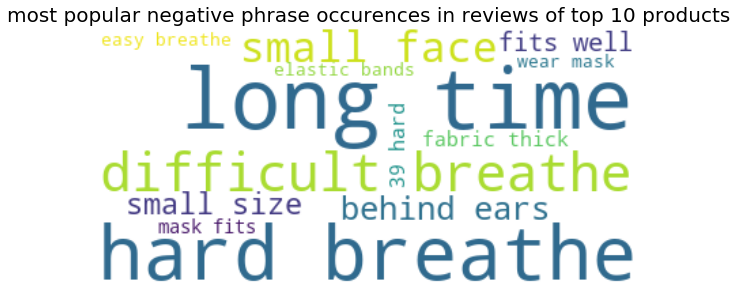

In [11]:
d = create_ngrams(top_10_prods[top_10_prods["polarity"]<0]["clean_review_text"]).head(13)
create_WordCloud(d, emo="negative", coun = "reviews of top 10 products")

<b>Inference:</b><i>Analysing negative comments, we see that small masks are disliked because it makes breathing difficult, thick fabric, hurts behind the ears.</i>

<p>Analysis can be further improved by considering reviewed reviews. Reviewed reviews are only 27% of the entire data, but it can still give us an improved textual analysis considering we already have a clear picture of users opinion on the existing products from the previous analysis.</p>

<h4>Overall frequnce of most occuring phrases in all and negative reviewed reviews</h4>

<Figure size 432x288 with 0 Axes>

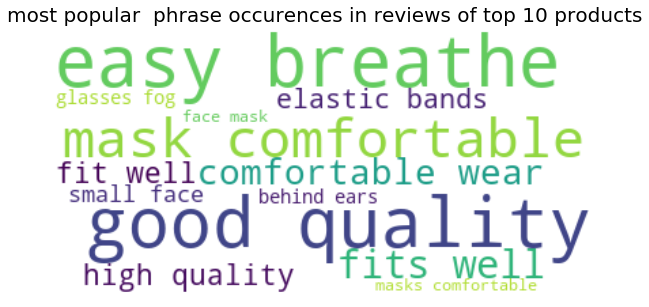

<Figure size 432x288 with 0 Axes>

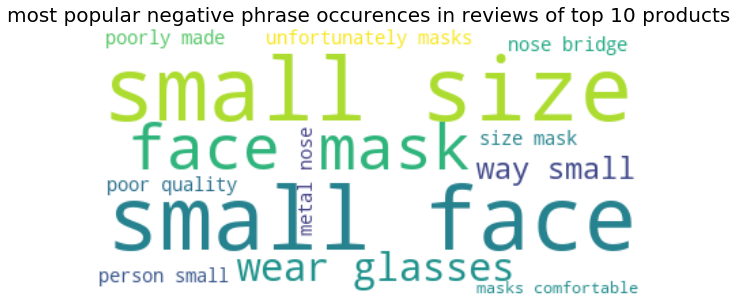

In [12]:
d = create_ngrams(top_10_prods[top_10_prods["reviewed"]==1]["clean_review_text"]).head(13)
create_WordCloud(d, coun="reviews of top 10 products")

d = create_ngrams(top_10_prods[(top_10_prods["polarity"]<0)&(top_10_prods["reviewed"]==1)]["clean_review_text"]).head(13)
create_WordCloud(d, emo="negative", coun = "reviews of top 10 products")

<b>Inference:</b><i>Reviewed comments further clarifies users requirements. In the negative comments, we can see that small masks also raises the issue of wearing glasses.</i>

<p><span style="color:blue">Phrase frequencies are best represented with wordclouds because, a simple table with the phrases and a frequency column would not emphasize the importance of a certain phrase. But through wordcloud which resizes phrases based on the frequency get the attention of the viewers. The above wordclouds can be improved with more text data cleaning.</span></p><br>
<p><span style="color:red">An issue with wordcloud is that it might be misleading sometimes. For example, if the frequency of phrases lie in the range of 5 to 1, then the one with maximum frequency is bigger in size. And the output would be the same if the range lies between 100 and 95. An option to display the absolute count on the viz can make the wordcloud less readable</span>

<b>Time series trend of reviews at company level</b>

<p>It would be interesting to see if customers are inclined towards buying masks of a certain company. That will help us understand how a new competitor is welcomed in the market</p>

In [13]:
df3 = top_10_prods.groupby(['Date', 'company_name']).agg({'id':'count'}).reset_index()
df3.rename(columns = {'id' : 'Count_of_Reviews'}, inplace=True)
df3 = df3[df3["company_name"]!="HIGUARD"]

fig = px.line(df3, x="Date", y="Count_of_Reviews", color="company_name", facet_col_wrap=2,
                 facet_col="company_name",height=600, facet_col_spacing=0.08,
             labels=dict(Date = "", Count_of_Reviews = ""))
fig.update_layout(showlegend=False, title = "Count of reviews companies selling top-10 products")
fig.update_layout(showlegend=False)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

In [14]:
df3 = top_10_prods.groupby(['Date', 'company_name']).agg({'id':'count'}).reset_index()
df3.rename(columns = {'id' : 'Count_of_Reviews'}, inplace=True)
df3 = df3[df3["company_name"].isin(["Kosette", "Kitsch", "SunJoy"])]

fig = px.line(df3, x="Date", y="Count_of_Reviews", color="company_name", facet_col_wrap=3,
                 facet_col="company_name",height=600, facet_col_spacing=0.08,
              labels=dict(Date = "", Count_of_Reviews = ""))
fig.update_layout(showlegend=False, title = "Count of reviews of Kosette, Kitsch vs. SunJoy")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

In [15]:
df3 = top_10_prods.groupby(['Date', 'company_name']).agg({'Rating':'mean'}).reset_index()
df3.rename(columns = {'Rating' : 'Avg_Rating'}, inplace=True)
df3 = df3[df3["company_name"].isin(["Kosette", "Kitsch", "SunJoy"])]

fig = px.line(df3, x="Date", y="Avg_Rating", color="company_name", facet_col_wrap=3,
                 facet_col="company_name",height=600, facet_col_spacing=0.08,
             labels=dict(Date = "", Avg_Rating = ""))
fig.update_layout(showlegend=False, title = "Average Rating of Kosette, Kitsch vs. SunJoy")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

<p>In the above graph it is interesting to see, how users prefer SunJoy (a new comer) over well-performing players like Kosette and Kitsch. The reviews for SunJoy drastically increased after their first appearance in September 2020 and their ratings too. In th last 3 months of the given data, SunJoy registered more number of reviews than other competitors.</p>

<p><span style="color:blue">I used line charts to represent the reviews counts and ratings because I used a continous variable and aggregated to get the final data. So I used a line chart to reprsent it. Bar graphs, scatter plots did not give readability. Scatter plot for multiple plots in a single line cluttered the view and bars in bar plots were less distinguishable because of the closeness of the values.</span></p><br>

<p><span style="color:red">One of the best way to approach the above visualization would be to create dynamic visualizations which allows the users to change and compare specific companies. Too many static charts can make information gain a little difficult.</span>

<h4>Understanding customer views about the products of the three companies</h4>

<p>Understanding the most popular phrases of reviews registered for the above three companies helps us understand if SunJoy tried something new to attract more customers to buy their product.</p>

<Figure size 432x288 with 0 Axes>

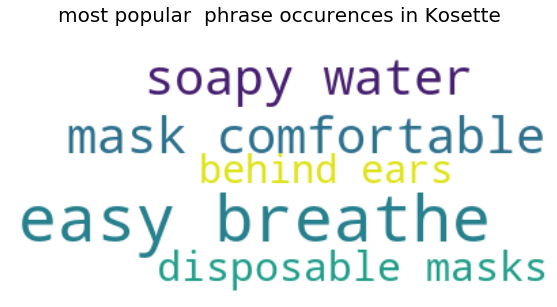

<Figure size 432x288 with 0 Axes>

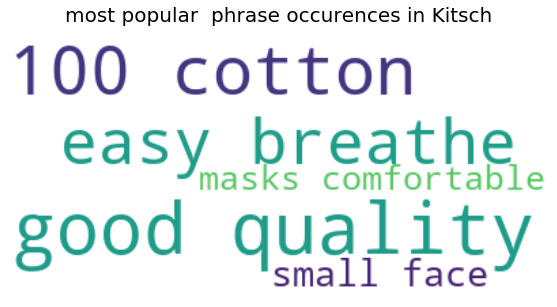

<Figure size 432x288 with 0 Axes>

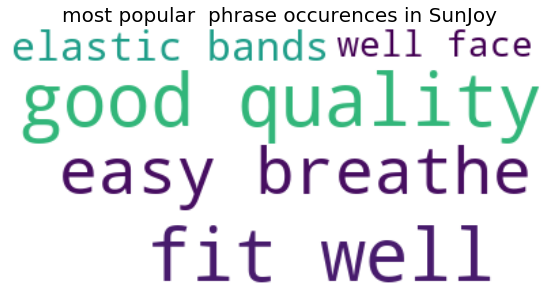

In [16]:
d = create_ngrams(merged_df[(merged_df["company_name"]=="Kosette")&(merged_df["reviewed"]==1)&(merged_df["Date"]>=pd.to_datetime("2020-09-01"))]["clean_review_text"]).head(5)
create_WordCloud(d, coun = "Kosette")
print("\n")
d = create_ngrams(merged_df[(merged_df["company_name"]=="Kitsch")&(merged_df["reviewed"]==1)&(merged_df["Date"]>=pd.to_datetime("2020-09-01"))]["clean_review_text"]).head(5)
create_WordCloud(d, coun = "Kitsch")
print("\n")
d = create_ngrams(merged_df[(merged_df["company_name"]=="SunJoy")&(merged_df["reviewed"]==1)]["clean_review_text"]).head(5)
create_WordCloud(d, coun = "SunJoy")

<b>Inference:</b><i>In Kosette and Kitsch reviews have occurrences of "soapy water" and "small face" and the term occurrencs are nearly the same in both the companies. But in Sunjoy, the reviews are particularly hilighting the fit of the masks and the elasticity.</i><br>
<b>Why?</b><i> Probably, SunJoy's products are performing well because it does not get worn out quickly because of the elasticity.</i>

<br></br>
<br></br>

<h2>3. What different profiles of consumers buy masks?</h2>

<p>Consumers can be from different gographical location. So to understand different profiles of consumers, first it is important to understand the distribution of consumers from the data.</p>

<h4>Geographical distribution of consumers</h4>

In [17]:
country_revs = merged_df.groupby(['Country_Code']).agg({'id' : 'count'}).reset_index()
country_revs["Country"] = ["Brazil", "Canada", "Denmark", "France", "Israel", "Japan", "South Korea", "Mexico",
                          "Russia", "South Africa", "Taiwan", "United States"]
fig = px.pie(country_revs, values='id', names = 'Country_Code', title="Geographical Distribution of Reviews",
            height=600)
fig.update_traces(textinfo = 'percent+label')
fig.show()

<b>Inference:</b><i>82% of the consumers are from the United States and Russia. Since 82% of the consumers are from two countries, we can narrow the analyses and specifically look at consumers belonging to the two countries. It will also help in handling noise</i>

<p><span style="color:blue">I chose to represent pie-chart for the representation of consumer geographical distribution because there are 12 different locations and representing in any kind bar graph would occupy more width. In a pie chart, the prominent locations are highlighted with bigger proportion in the pie and the insignificant proportions are given very minimal chunk of the pie. This again makes the viewer focus on the more significant contributions.</span></p>

<h4>Understanding consumers from Russia and the United States</h4>

In [18]:
# Prefered purchase type (bulk vs single piece) for masks in the US and Russia
us_ru_reviews = merged_df[merged_df["Country_Code"].isin(['US', 'RU'])]

fig = px.histogram(us_ru_reviews,
                      x="Country_Code",
                      color="Purchase_Type",
                      barnorm = "percent",
                      text_auto= True,
                      color_discrete_sequence=["mediumvioletred", "seagreen"],
                ).update_layout (

                    title={
                            "text": "Percentage of Bulk vs Single piece mask purchase in Russia and US",
                            "x": 0.5,
                            
                          },
                    xaxis_title = None,
                    bargap = 0.7,
                ).update_xaxes(categoryorder='total descending', visible = True, showticklabels = True).update_yaxes(visible = False)


fig.show()

<b>Inference:</b><i>Consumers in the United States mostly prefer bulk purchase of masks when compared to the consumers from Russia. The exhibits different purchasing patterns among customers from these two countries. Although bulk masks are usually preferred in both the countries, the difference in percentage for Russian consumers is marginal. Based on this understanding we can recommend more single piece masks to the Russians and more bulk masks to the Americans.</i>

<p><span style="color:blue">I chose to represent the purchase type percentage using 100% stacked bar chart because of the compactness it holds. It immediately gives users an understanding of difference in percentages and also easy readability. If it were for other charts like bar graph, then there would be issues of different scales. E.g, US is nearly 50%, so in a bar graph Russian representation always look smaller when compared to the US.</span></p>

<h4>Total sales and average price per mask</h4>

In [19]:
finance_us_ru = us_ru_reviews.groupby(["Country_Code", "product_id"]).agg({'id':'count'}).reset_index()
products_df1["num_masks"] = products_df1["product_name"].apply(lambda x: int(x.split(",")[-1].strip().split()[0]))
products_df1["Price_per_piece"] = products_df1["product_price"] / products_df1["num_masks"]
finance_us_ru = pd.merge(finance_us_ru, products_df1, on=["product_id"])
finance_us_ru["tot_masks_purch"] = finance_us_ru["id"]*finance_us_ru["num_masks"]
finance_us_ru["profit"] = finance_us_ru["Price_per_piece"]*finance_us_ru["tot_masks_purch"]

In [20]:
weight_avg = finance_us_ru.groupby(['Country_Code']).agg({'profit' : 'sum', 'tot_masks_purch' : 'sum', 'id' : 'sum'}).reset_index()
weight_avg.rename(columns = {'id' : 'Total masks sold', "profit" : 'Total Sales (AUD)'}, inplace=True)
weight_avg["W_Avg Price per Piece"] = weight_avg['Total Sales (AUD)'] / weight_avg["tot_masks_purch"]

weight_avg[["Country_Code", 'Total masks sold', 'Total Sales (AUD)',  "W_Avg Price per Piece"]]

Country_Code  Total masks sold  Total Sales (AUD)  W_Avg Price per Piece
0           RU              1275           18731.52               1.535245
1           US              1806           30370.49               1.634140

<b>Inference:</b><i>The weighted average price per mask is only 0.1 AUD more in the US when compared to Russia. This probably explains lower sales in Russia. To boost the sales in the Russian market, we will need to understand the specific requirements of consumers from these countries.</i>

<p><span style="color:blue">When multiple numerical values are presented to the users, I felt a tabular representation of the data can be more valuable compared to any charts.</span></p>

<h4>Consumers' mask requirements</h4>

In [21]:
# Textual analysis 
us_ru_rev_clean = us_ru_reviews[~((us_ru_reviews["polarity"]==0)&(us_ru_reviews["subjectivity"]==0))]
us_ru_rev_clean["len_text"] = us_ru_rev_clean["clean_review_text"].apply(lambda x: len(x.split()))

# This dataframe contains reviews that has more than average number of words in the entire review
us_ru_rev_clean_2 = us_ru_rev_clean[us_ru_rev_clean["len_text"] >= us_ru_rev_clean["len_text"].mean()]

<Figure size 432x288 with 0 Axes>

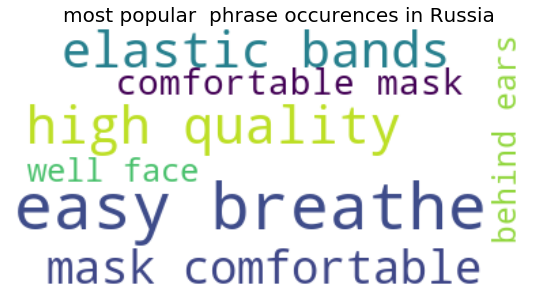

<Figure size 432x288 with 0 Axes>

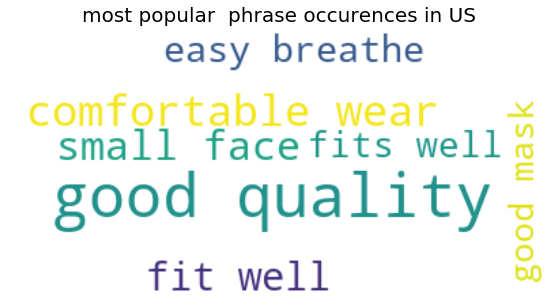

In [22]:
d = create_ngrams(us_ru_rev_clean[us_ru_rev_clean["Country_Code"]=="RU"]["clean_review_text"]).head(7)
create_WordCloud(d, coun = "Russia")

d = create_ngrams(us_ru_rev_clean[us_ru_rev_clean["Country_Code"]=="US"]["clean_review_text"]).head(7)
create_WordCloud(d, coun = "US")

<b>Inference:</b><i>Consumers from both the countries highlight common features of masks. But there still exists a difference in their comments. From the wordcloud we see that, Russians probably highlight comfort through high quality and mask elasticity. On the other hand, consumers from the US highlight comfort through good quality and fit of the masks.</i>

In [23]:
# us_ru_rev_clean[(us_ru_rev_clean["polarity"]<0)&(us_ru_rev_clean["clean_review_text"].str.contains("filtration"))]["clean_review_text"].tolist()

<Figure size 432x288 with 0 Axes>

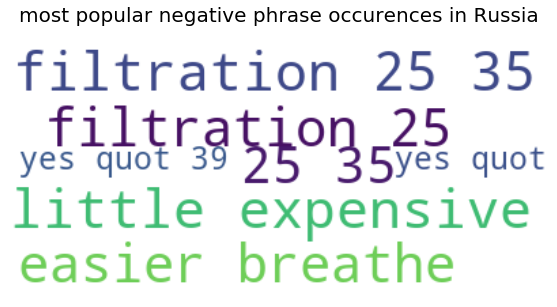

<Figure size 432x288 with 0 Axes>

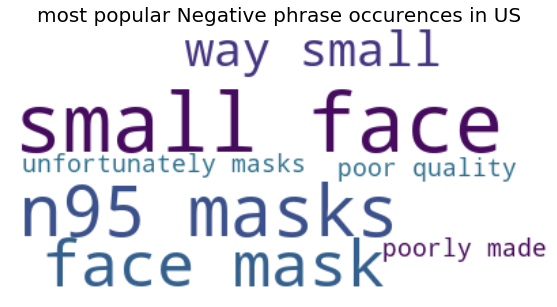

In [24]:
d = create_ngrams(us_ru_rev_clean[(us_ru_rev_clean["Country_Code"]=="RU")&(us_ru_rev_clean["polarity"]<0)&(us_ru_rev_clean["reviewed"]==1)]["clean_review_text"]).head(7)
create_WordCloud(d, emo="negative", coun = "Russia")

d = create_ngrams(us_ru_rev_clean[(us_ru_rev_clean["Country_Code"]=="US")&(us_ru_rev_clean["polarity"]<0)&(us_ru_rev_clean["reviewed"]==1)]["clean_review_text"]).head(7)
create_WordCloud(d, emo="Negative", coun = "US")

<b>Inference:</b><i>There is yet again a stark difference in consumers' dislikes in their purchase. Consumers from Russia are specific of the flaw of filtration in their masks. Probably it is way easier to breath and not providing any filtration at all. Also, they find masks expensive. In the US, the n95 masks in general are highlighted in negative reviews. The quality and the size of the masks are most highlighted.</i>

<br><br>

<h1>Conclusion</h1>

<p>Analysing the data was a truly a great experience. Two things that fascinated me in the process. One, the interlink of features in the dataset and how together they weave into a story. And the manifold visualizing options for a single representation. To choose one among the many was equally an arduous task as data cleaning and analysis. I have learnt through this assignment that visualization is one of the most important process in data analysis because my viewer might get overwhelmed with tabular form of numbers. Visualization helps with lower cognition load and easy comprehension of the problem.</p>

<p>From the above analysis I saw that use of masks drastically increased post the impact of the delta variant (From September 2020). This reflects the increased awareness among people in maintaining good hygiene. Interestingly, the ratings for the products have also drastically increased indicating the competitors are producing quality products in the market. Though the quality of these products have remained high, there still exists gaps that were identified in the analysis. </p>
<br>
<p>First, bulk masks are preferred by many consumers. This might be because having a single mask requires frequent washing which adds on to its maintenance. Also, users prefer a range of masks in bulk purchase. It lies between 3 to 10. </p>
<p><b>Suggestion:</b> <span style="color:green">In general disposable masks with 3 to 10 masks in a pack is popular amongst consumers.</span></p>
<br>
<p>Second, on analysing consumer reviews I saw that consumers rate masks on the following aspects:</p>
<li><b>Fabric Quality</b></li>
<li><b>Comfort</b></li>
<li><b>Elasticity</b></li>
<li><b>Fit of the Masks</b></li>
<p>Specifically looking at negative comment of the users, I found that small fit masks are disliked the most for the same aspects listed above.</p>
<p>I also found that SunJoy, a new comer in the market of safety masks performed well after their first appearance. On analysing it was interesting to see that "fit" and "elasticity" were highly mentioned in the customer reviews when compared to the reviews of top-2 performing companies</p>
<p><b>Suggestion:</b> <span style="color:green">With a good idea on what need to be focused while designing masks, one needs to be cognizant of the size of the masks to ensure the product performs well in the market. High attention must be given to the fit and elasticity of maks (like we saw in SunJoy's case). Probably, designing masks based on face shapes can be a hit in the market.</span></p>
<br>
<p>Third, I looked at specific consumer interests based on their geographical location. I found that 82% of the consumers are from the US and Russia. These two markets can give maximum profits. The geographic location engenders stark differences in consumer requirements. I have summarized the insights below:</p>
<li><b>Russian consumers equally prefer single and bulk masks. But consumers from the US prefer bulk masks.</b></li>
<li><b>Weighted average price of a single mask in Russia and US differs only by 0.1 AUD which makes purchase of masks expensive to customers from Russia.</b></li>
<li><b>Comfort for Russian consumers (high quality and elasticity) is different from that of the US (good quality and fit)</b></li>
<li><b>In Russia, the consumers find filtrations used in the masks too pervious (making it easier to breath), and it is expensive too. In the US, n95 masks perform bad because of the small size.</b></li>
<p><b>Suggestion:</b> <span style="color:green">One needs to accommodate the differences (highlighted above) between the two well performing markets and needs to design geographic specific masks instead of general masks to everyone. Also, the preference of bulk and single piece masks might play a significant role in boosting profits from both the countries at the same time ensuring the consumers are happy with the products. </span></p>